## Hydra for map-space datacubes

Phil Bull, _2023-01-26_

In [2]:
import numpy as np
import pylab as plt
import scipy.linalg
from scipy.sparse.linalg import cg, gmres, LinearOperator
import time

In [3]:
np.random.seed(10)

## Generate test data
This is based on a simple Gaussian foreground model and Gaussian random signal field.

In [4]:
x = np.linspace(-10., 10., 60) # degrees
y = np.linspace(-10., 10., 40) # degrees
nu = np.linspace(700., 950., 48) # MHz

nu_ref = 1000. # MHz

### 21cm signal

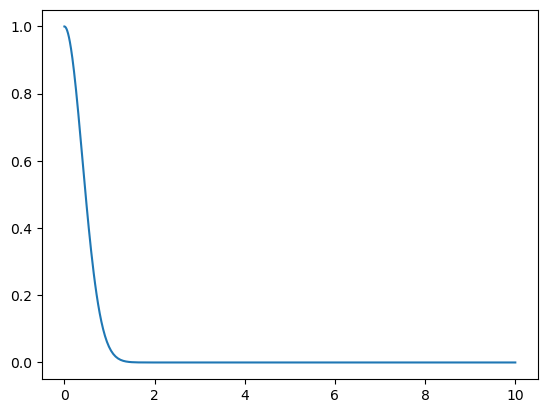

In [5]:
# Basic 21cm signal realisation

# Simple power spectrum model
sigma_pk = 0.4
theory_pspec = lambda k: np.exp(-0.5 * (k / sigma_pk)**2.)

# Plot power spectrum model
plt.subplot(111)
kk = np.logspace(-3., 1., 200)
plt.plot(kk, theory_pspec(kk))

In [6]:
# Unit Gaussian random map
s = np.random.randn(x.size, y.size, nu.size)
s_fft = np.fft.fftn(s)
print(s.shape, s_fft.shape)

# Fourier modes
_kx = np.fft.fftfreq(x.size, d=x[1]-x[0])
_ky = np.fft.fftfreq(y.size, d=y[1]-y[0])
_kz = np.fft.fftfreq(nu.size, d=nu[1]-nu[0])
kx, ky, kz = np.meshgrid(_kx, _ky, _kz, indexing='ij')
k = np.sqrt(kx**2. + ky**2. + kz**2.)

# Power spectrum in each cell
s = np.fft.ifftn(s_fft * np.sqrt(theory_pspec(k))).real

(60, 40, 48) (60, 40, 48)


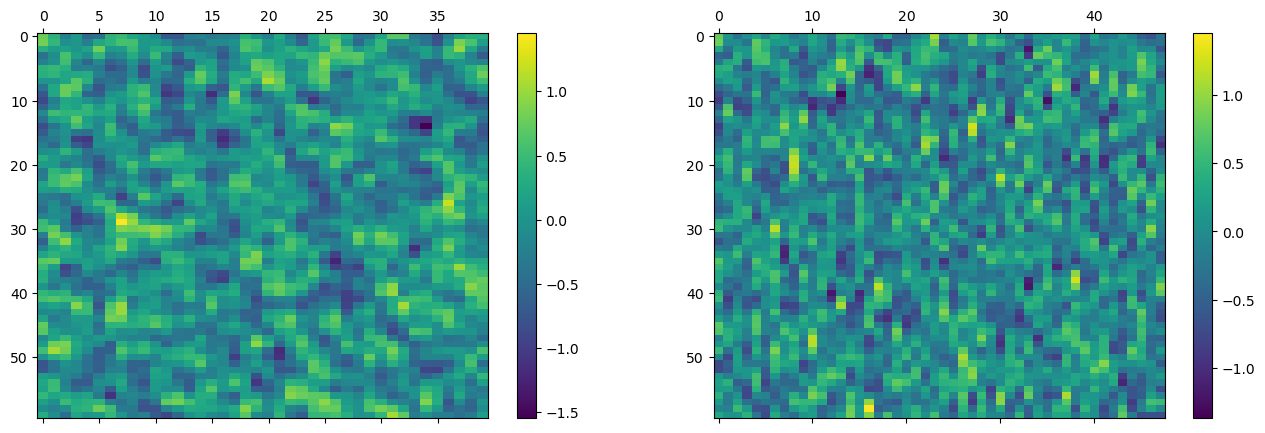

In [7]:
# Plot slices
plt.subplot(121)
plt.matshow(s[:,:,0], aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(122)
plt.matshow(s[:,0,:], aspect='auto', fignum=False)
plt.colorbar()

plt.gcf().set_size_inches((16., 5.))

### Foreground simulation

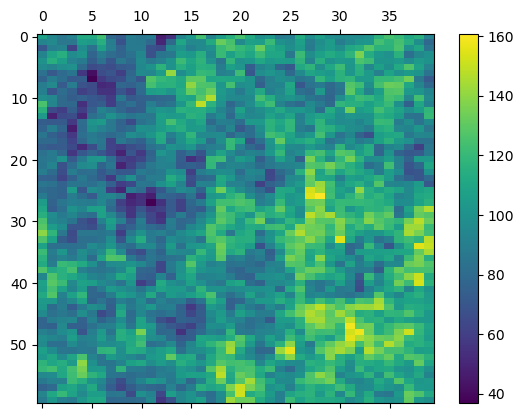

In [8]:
# Unit Gaussian random map
fg_amp = np.random.randn(x.size, y.size)
fg_amp_fft = np.fft.fftn(fg_amp)

kx2d, ky2d = np.meshgrid(_kx, _ky, indexing='ij')
k2d = np.sqrt(kx2d**2. + ky2d**2.)

# Power-law amplitude FG model
theory_pspec_fg = lambda k: (k + 1e-5)**-2.
fg_amp = np.fft.ifftn(fg_amp_fft * np.sqrt(theory_pspec_fg(k2d))).real
fg_amp -= np.mean(fg_amp)
fg_amp = 10.*fg_amp + 100.

# Plot map
plt.subplot(111)
plt.matshow(fg_amp, aspect='auto', fignum=False)
plt.colorbar()

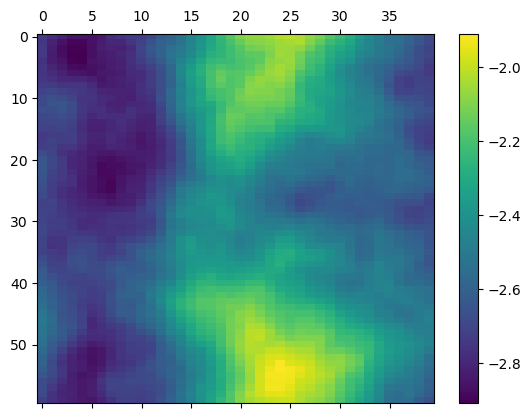

In [9]:
# Unit Gaussian random map
fg_beta = np.random.randn(x.size, y.size)
fg_beta_fft = np.fft.fftn(fg_beta)

# Power-law amplitude FG model
theory_pspec_beta = lambda k: (k/1e-2 + 1e-5)**-4.
fg_beta = np.fft.ifftn(fg_beta_fft * np.sqrt(theory_pspec_beta(k2d))).real
fg_beta -= np.mean(fg_beta)
fg_beta /= (fg_beta.max() - fg_beta.min())
fg_beta = -2.5 + fg_beta

# Plot map
plt.subplot(111)
plt.matshow(fg_beta, aspect='auto', fignum=False)
plt.colorbar()

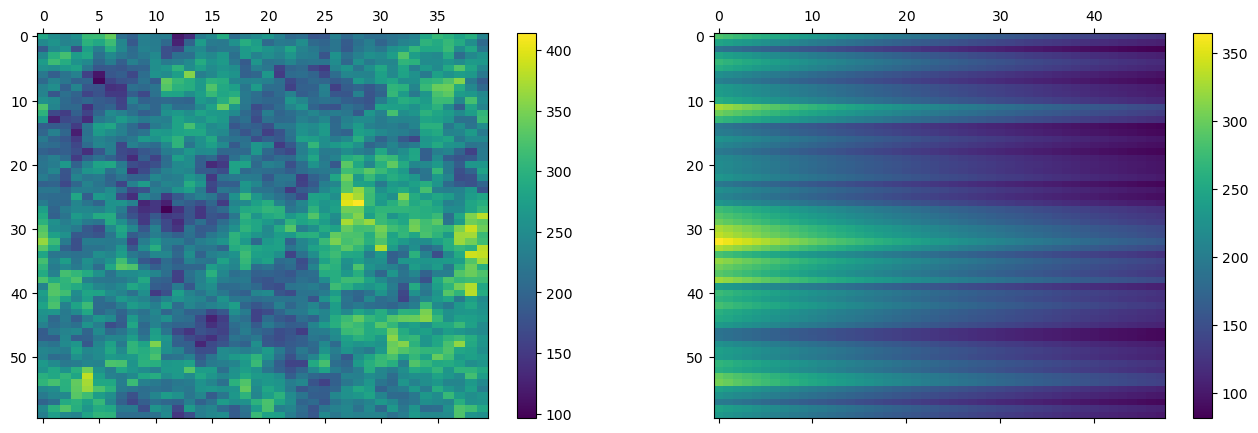

In [10]:
# Combine to make foreground data cube
fg = fg_amp[:,:,np.newaxis] * (nu / nu_ref)[np.newaxis,np.newaxis,:]**fg_beta[:,:,np.newaxis]

# Plot slices
plt.subplot(121)
plt.matshow(fg[:,:,0], aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(122)
plt.matshow(fg[:,0,:], aspect='auto', fignum=False)
plt.colorbar()

plt.gcf().set_size_inches((16., 5.))

### Noise

In [11]:
t_obs = 10. # sec
dnu = nu[1] - nu[0] # MHz
noise_var = fg**2. / (t_obs * dnu*1e6)

In [12]:
np.sqrt(noise_var.min()), np.sqrt(noise_var.max())

(0.005798118079366566, 0.05674500603481327)

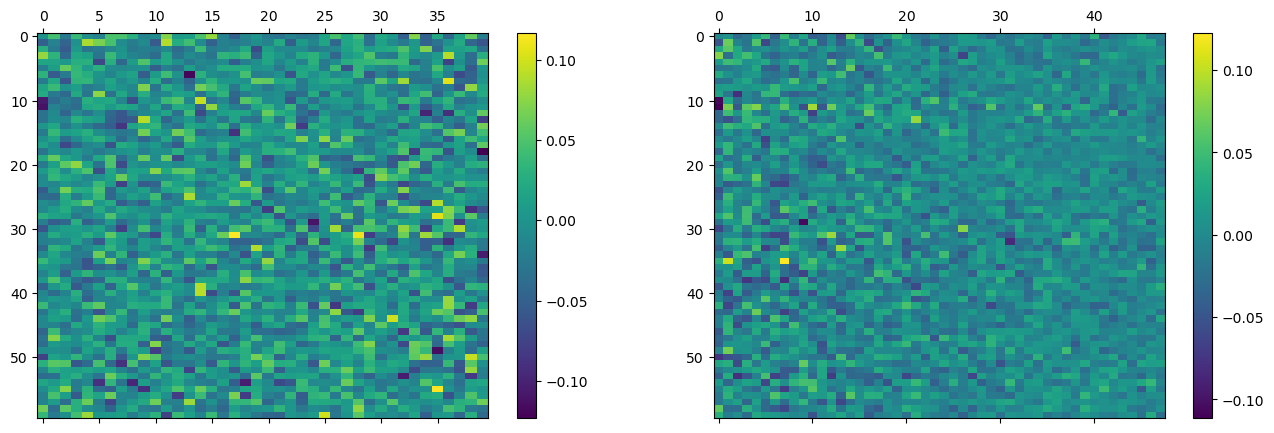

In [13]:
# Generate noise
n = np.random.randn(x.size, y.size, nu.size) * np.sqrt(noise_var)

# Plot slices
plt.subplot(121)
plt.matshow(n[:,:,0], aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(122)
plt.matshow(n[:,0,:], aspect='auto', fignum=False)
plt.colorbar()

plt.gcf().set_size_inches((16., 5.))

### Combined data

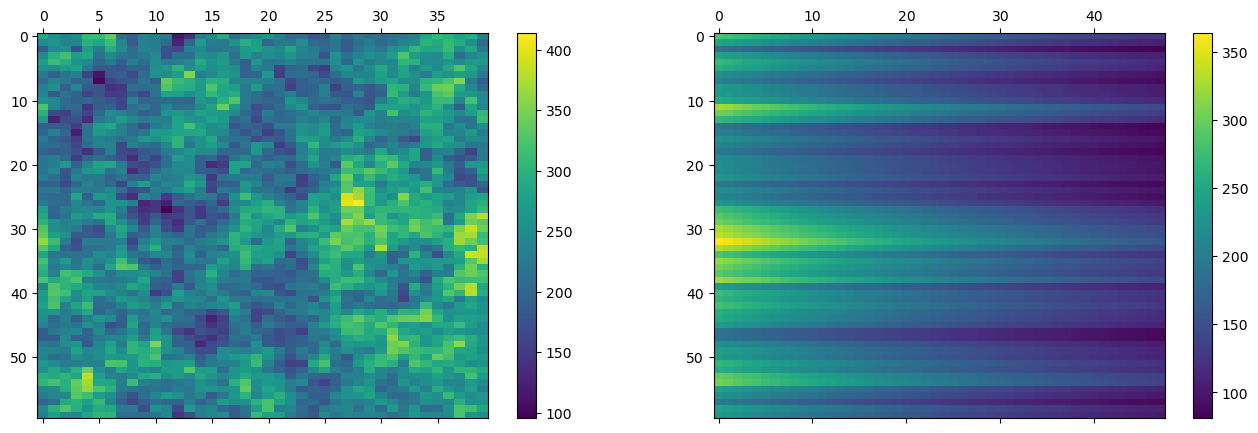

In [14]:
# Ignore beam for now!
d = fg + s + n

# Plot slices
plt.subplot(121)
plt.matshow(d[:,:,0], aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(122)
plt.matshow(d[:,0,:], aspect='auto', fignum=False)
plt.colorbar()

plt.gcf().set_size_inches((16., 5.))

# Gaussian Constrained Realisation equations

In [15]:
def unpack_signal_vec(x, fft_shape, repack=False):
    """
    Take a block vector of signal coefficients and unpack into a 3D array.
    
    The block vector has the real parts first, then the imaginary ones.
    """
    if repack:
        xx = np.concatenate((x.flatten().real, x.flatten().imag))
    else:
        # Combine real and imaginary blocks, and reshape into 3D map
        xx = 1.0 * x[:x.size//2].reshape(fft_shape) \
           + 1.j * x[x.size//2:].reshape(fft_shape)
    return xx


def apply_proj_signal(x, transpose=False):
    """
    Projection operator to go from 21cm signal coefficients to a 
    datacube (for a single dish).
    
    As a matrix, the operator has shape `(Npix, Nmodes)`. We return 
    an array with the shape of a 3D datacube however.
    """
    if transpose:
        return np.fft.rfft2(x) # Fourier space
    else:
        return np.fft.irfft2(x) # real space


def unpack_fg_vec(x, fg_shape, repack=False):
    """
    Take a block vector of FG amplitude coefficients and turn it 
    into a 2D map of amplitudes per FG mode.
    """
    if repack:
        return x.flatten()
    else:
        return x.reshape(fg_shape)


def apply_proj_fg(x, data_shape, basis_vec, transpose=False):
    """
    Projection operator to go from a 2D foreground amplitude map 
    per mode to a datacube (for a single dish).
    
    Parameters:
        x (array_like):
            Array of FG amplitudes per 2D pixel and per mode, of 
            shape `(Nx, Ny, Nmodes)`. If `transpose=True`, this 
            has shape `(Nx, Ny, Nfreqs)` instead.
        data_shape (tuple):
            The shape of the data cube for each dish, which is 
            expected to be `(Nx, Ny, Nfreqs)`.
        basis_vec (array_like):
            An array of basis vectors, of shape `(Nmodes, Nfreqs)`.
    """
    # Check x shape
    assert len(x.shape) == 3, \
        "Input vector x must be 3D array of shape (Nx, Ny, Nmodes)"

    # Get array shapes
    if transpose:
        Nx, Ny, Nfreqs = x.shape
        assert Nfreqs == data_shape[2]
        Nmodes = basis_vec.shape[0]
    else:
        Nx, Ny, Nmodes = x.shape
        assert Nmodes == basis_vec.shape[0]
        Nfreqs = data_shape[2]
    assert (data_shape[0] == Nx) and (data_shape[1] == Ny), \
        "Amplitude vector x and data_shape are not compatible."
    assert basis_vec.shape == (Nmodes, Nfreqs), \
        "basis_vec array has incompatible shape; should be (Nmodes, Nfreqs)"
    
    # Apply operator (or its transpose)
    if transpose:
        # Return array with same shape as FG amplitude array
        # (Nx, Ny, Nfreqs) * (Nfreqs, Nmodes) -> (Nx, Ny, Nmodes)
        yy = np.matmul(x, basis_vec.T)
    else:
        # Return array with same shape as datacube (per dish)
        # (Nx, Ny, Nmodes) * (Nmodes, Nfreqs) -> (Nx, Ny, Nfreqs)
        yy = np.matmul(x, basis_vec)
    
    print("shape:", yy.shape)
    return yy


def _polynomial_basis_vec(freqs, nmodes, func):
    """
    Generic function to generate basis vector array from a given 
    type of polynomial basis.
    """
    # Normalise frequencies to range [-1, 1]
    x_nu = 2.*(nu - nu.min()) / (nu.max() - nu.min()) - 1.
    
    # Empty array for vectors, of shape (Nmodes, Nfreqs)
    basis_vec = np.zeros((nmodes, nu.size))
    
    # Get vector for each mode
    x = np.zeros(nmodes)
    for i in range(nmodes):
        # Set all but current mode to zero
        x *= 0.
        x[i] = 1.
        
        # Calculate vector for this mode
        basis_vec[i] = func(x)(x_nu)
    return basis_vec


def legendre_basis_vec(freqs, nmodes):
    """
    Matrix of Legendre modes vs frequency.
    """
    return _polynomial_basis_vec(freqs=freqs, 
                                 nmodes=nmodes, 
                                 func=np.polynomial.Legendre)

In [21]:
def apply_lhs_matrix(x, inv_noise_var, Sinv, Finv, basis_vec, fft_shape):
    """
    Apply block matrix operator to solution vector x.
    
    FIXME: Sinv has to be 1D due to size limitations...
    
    Parameters:
        x (array_like):
            1D block vector with dimensions (Nmodes_s + Nmodes_f).
        inv_noise_var (array_like):
            Array containing the diagonal of inverse noise covariance (N^-1) matrix. 
            Has shape `(Nx, Ny, Nfreqs, Ndish)`.
        Sinv (array_like):
            Diagonal of inverse covariance matrix for the signal (in Fourier space), 
            of shape `(Nmodes_s,)`.
        Finv (array_like):
            Diagonal of inverse covariance matrix for the FG modes, of shape `(Nmodes_f,)`.
        basis_vec (array_like):
            Array of FG basis vectors as a function of frequency, shape `(Nmodes_f, Nfreqs)`.
        fft_shape (tuple):
            The shape of the 3D FFT'd data, which will be `(Nx, Ny, rfft_freq(Nfreqs).size)` 
            since we are using the real FFT.
        
    """
    # Get shapes
    Nx, Ny, Nfreqs, Ndish = inv_noise_var.shape
    Nmodes_s = Sinv.shape[0]
    Nmodes_f = Finv.shape[0]
    fg_shape = (fft_shape[0], fft_shape[1], Nmodes_f)
    data_shape = inv_noise_var.shape
    fg_shape = (Nx, Ny, Nmodes_f)
    
    # Unpack x block vector
    _xs = x[:Nmodes_s]
    _xf = x[Nmodes_s:]
    xs = unpack_signal_vec(_xs, fft_shape)
    xf = unpack_fg_vec(_xf, fg_shape)
    
    # Since the signal and FG components don't depend on dish, 
    # the action of each of these blocks of the operator can be replaced 
    # with an operation on the sum of the per-dish inverse variances
    # e.g. `U_s^T N^-1 U_s` becomes `U_s^T (Sum_d N_d^-1) U_s`, where 
    # `d` labels the dishes
    Ninv_tot = np.sum(inv_noise_var, axis=-1)
    
    # Apply matrix operator in blocks
    M_ss = Sinv \
         + apply_proj_signal(Ninv_tot \
                             * apply_proj_signal(xs, transpose=False), 
                             transpose=True) # (Nx_rfft, Ny_rfft, Nfreq_rfft)
    M_sf = apply_proj_signal(Ninv_tot \
                             * apply_proj_fg(xf, data_shape, basis_vec, transpose=False), 
                             transpose=True) # (Nx_rfft, Ny_rfft, Nfreq_rfft)
    M_fs = apply_proj_fg(Ninv_tot \
                         * apply_proj_signal(xs, transpose=False), 
                         data_shape, 
                         basis_vec,
                         transpose=True) # (Nx, Ny, Nmodes)
    M_ff = Finv \
         + apply_proj_fg(Ninv_tot \
                         * apply_proj_fg(xf, data_shape, basis_vec, transpose=False), 
                         data_shape, 
                         basis_vec,
                         transpose=True) # (Nx, Ny, Nmodes)
    
    # Combine blocks and re-pack into 1D vector shape
    y_s = unpack_signal_vec(M_ss + M_sf, fft_shape, repack=True)
    y_f = unpack_fg_vec(M_fs + M_ff, fg_shape, repack=True)
    y = np.concatenate((y_s.flatten(), y_f.flatten()))
    return y


# apply_lhs_matrix(x, Ninv, Sinv, Finv, basis_vec, fft_shape, data_shape, fg_shape)
def construct_rhs(data, inv_noise_var, Sinv, Finv, sbar, fbar, realisation=False):
    """
    Construct RHS operator for the block linear system.
    
    Parameters:
        data (array_like):
            Data array, with shape `(Nx, Ny, Nfreqs, Ndish)`.
        inv_noise_var (array_like):
            Array containing the diagonal of inverse noise covariance (N^-1) matrix. 
            Has shape `(Nx, Ny, Nfreqs, Ndish)`.
        Sinv (array_like):
            Diagonal of inverse covariance matrix for the signal (in Fourier space), 
            of shape `(Nmodes_s,)`.
        Finv (array_like):
            Diagonal of inverse covariance matrix for the FG modes, of shape `(Nmodes_f,)`.
        sbar (array_like):
            Prior mean values for the signal model, of shape (Nmodes_s,).
        fbar (array_like):
            Prior mean values for the FG model, of shape (Nmodes_f,).
        
        realisation (bool):
            If True, include the random fluctuation terms in the vector. Otherwise, exclude 
            these terms (to solve the Wiener Filter equation).
        
        basis_vec (array_like):
            Array of FG basis vectors as a function of frequency, shape `(Nmodes_f, Nfreqs)`.
        fft_shape (tuple):
            The shape of the 3D FFT'd data, which will be `(Nx, Ny, rfft_freq(Nfreqs).size)` 
            since we are using the real FFT.
    """
    Nx, Ny, Nfreqs, Ndish = data.shape
        
    # Switch to turn random realisations on or off
    realisation_switch = 1.0 if realisation else 0.0
    
    # Calculate terms with the same shape as the data / signal / FGs
    omega_d = realisation_switch * np.random.randn(*data.shape)
    omega_s = realisation_switch * np.fft.rfft2(np.random.randn(Nx, Ny, Nfreqs))
    omega_f = realisation_switch * np.random.randn(*fbar.shape)
    
    # Data-dependent terms; sum over last axis (dishes), since no dependence on dish
    yd = np.sum(inv_noise_var * data + np.sqrt(inv_noise_var) * omega_d, axis=-1)
    bd = apply_proj_signal(yd, transpose=True)
    
    # Construct arrays
    bs = bd + Sinv * sbar + np.sqrt(Sinv) * omega_s
    bf = bd + Finv * fbar + np.sqrt(Finv) * omega_f
    
    # FIXME!!! Might not be right
    # Reshape into expected format
    ys = unpack_signal_vec(bs, fft_shape, repack=True)
    yf = unpack_fg_vec(bf, fg_shape, repack=True)
    return np.concatenate((ys.flatten(), yf.flatten()))

In [22]:
# Precompute basis vector array
Nmodes = 3
basis_vec = legendre_basis_vec(nu, Nmodes)

# Determine array shapes
rfft_shape = (np.fft.fftfreq(d.shape[0]).size, 
              np.fft.fftfreq(d.shape[1]).size, 
              np.fft.rfftfreq(d.shape[2]).size)
data_shape = d.shape
fg_shape = (d.shape[0], d.shape[1], Nmodes)
print("rfft_shape:", rfft_shape)
print("data_shape:", data_shape)
print("fg_shape:  ", fg_shape)
print("")

# Construct Ninv, shape (Nx, Ny, Nfreqs, Ndish)
Ndish = 4
Ninv = (1e-1)**-2. * np.ones((d.shape[0], d.shape[1], d.shape[2], Ndish))
Sinv = np.ones(2*np.prod(rfft_shape)) # FIXME
Finv = (np.mean(np.abs(fg)))**-2. * np.ones(Nmodes) # FIXME

# Construct suitable x vector
xvec = np.zeros(2*np.prod(rfft_shape) + np.prod(fg_shape))
xvec[3] = 1.
xvec[-3] = 1.

# Apply matrix operator
y = apply_lhs_matrix(xvec, Ninv, Sinv, Finv, basis_vec, rfft_shape)
print(y.shape, xvec.shape, np.prod(data_shape))

rfft_shape: (60, 40, 25)
data_shape: (60, 40, 48)
fg_shape:   (60, 40, 3)



ValueError: operands could not be broadcast together with shapes (120000,) (60,40,25) 

In [17]:
y.sum()

26421.13208195576

In [1]:
## Older code, mostly obsolete

In [18]:
def unpack_solution(x, fft_shape, sqrtS=None):
    """
    Reorder solution vector and perform inverse FFT on it. 
    """
    # Don't multiply by sqrt of prior covariance if not specified
    if sqrtS is None:
        sqrtS = 1.
        
    # Combine real and imaginary, and reshape into 2D map and inv. FFT
    xx = 1.0 * x[:x.size//2].reshape(fft_shape) \
       + 1.j * x[x.size//2:].reshape(fft_shape)
    x_map = np.fft.irfft2(sqrtS * xx)
    return x_map


def apply_operator(x, beta, dimensionless_freq, inv_noise_var, sqrtS):
    """
    Apply operator for FG amplitudes (in Fourier space).
    """
    fft_shape = sqrtS.shape
    
    # Combine real and imaginary, and reshape into 2D map and inv. FFT
    xx = 1.0 * x[:x.size//2].reshape(fft_shape) \
       + 1.j * x[x.size//2:].reshape(fft_shape)
    x_map = np.fft.irfft2(sqrtS * xx) # multiply by S^1/2 and inverse FFT
    
    # Multiply by spectral function (squared because N^-1 is diagonal and freq. factor is real)
    # Last axis is the frequency axis
    y = x_map[:,:,np.newaxis] \
      * inv_noise_var \
      * (dimensionless_freq[np.newaxis, np.newaxis, :]**beta[:,:,np.newaxis])**2.
    
    # Do FFT again (per channel), sum over channels, and multiply by S^1/2 again
    xx = sqrtS * np.sum(np.fft.rfft2(y, axes=(0,1)), axis=-1)
    
    # Flatten and split again
    y = 1. + np.concatenate((xx.real.flatten(), xx.imag.flatten()))
    return y

In [19]:
def construct_rhs(data, beta, dimensionless_freq, inv_noise_var, sqrtS, realisation=False):
    """
    Construct RHS operator for the Fourier-space amplitudes of foregrounds 
    with power-law frequency dependence.
    """
    # Switch to turn random realisations on or off
    realisation_switch = 1.0 if realisation else 0.0
    
    # Calculate frequency factor
    freq_factor = dimensionless_freq[np.newaxis, np.newaxis, :]**beta[:,:,np.newaxis]
    
    # Calculate terms with the same shape as the data 
    omega_n = realisation_switch * np.random.randn(*data.shape)
    
    y = np.fft.rfft2(freq_factor * (inv_noise_var*data + np.sqrt(inv_noise_var)*omega_n), 
                     axes=(0,1))    
    # Sum, multiply by sqrt of prior cov, and add random term with shape of the param vector
    b = sqrtS * np.sum(y, axis=-1) \
      + np.fft.rfft2(np.random.randn(data.shape[0], data.shape[1]))
    
    # Reshape into expected format
    return np.concatenate((b.real.flatten(), b.imag.flatten()))

In [20]:
rfft_shape = (np.fft.fftfreq(d.shape[0]).size, 
              np.fft.rfftfreq(d.shape[1]).size)
xfreq = nu / nu_ref # dimensionless freq. (/1000 MHz)

sqrtS = 1e8 * np.ones(rfft_shape)

# Calculate RHS vector
b = construct_rhs(data=d, 
                  beta=fg_beta, 
                  dimensionless_freq=xfreq, 
                  inv_noise_var=1./noise_var,
                  sqrtS=sqrtS,
                  realisation=True)

In [21]:
def fg_amp_lhs_operator(x):
    return apply_operator(x=x, 
                          beta=fg_beta, 
                          dimensionless_freq=xfreq, 
                          inv_noise_var=1./noise_var, 
                          sqrtS=sqrtS)
fg_amp_lhs_shape = (2*rfft_shape[0]*rfft_shape[1],
                    2*rfft_shape[0]*rfft_shape[1])

# Construct LHS operator
fg_amp_linear_op = LinearOperator(matvec=fg_amp_lhs_operator,
                                  shape=fg_amp_lhs_shape)

In [22]:
# Run linear solver (N.B. x_soln needs to be rescaled by sqrtS)
t0 = time.time()
solver = gmres
x_soln, convergence_info = solver(fg_amp_linear_op, b)
print(convergence_info)
print("Solver took %7.3f sec" % (time.time() - t0))

0
Solver took   0.292 sec


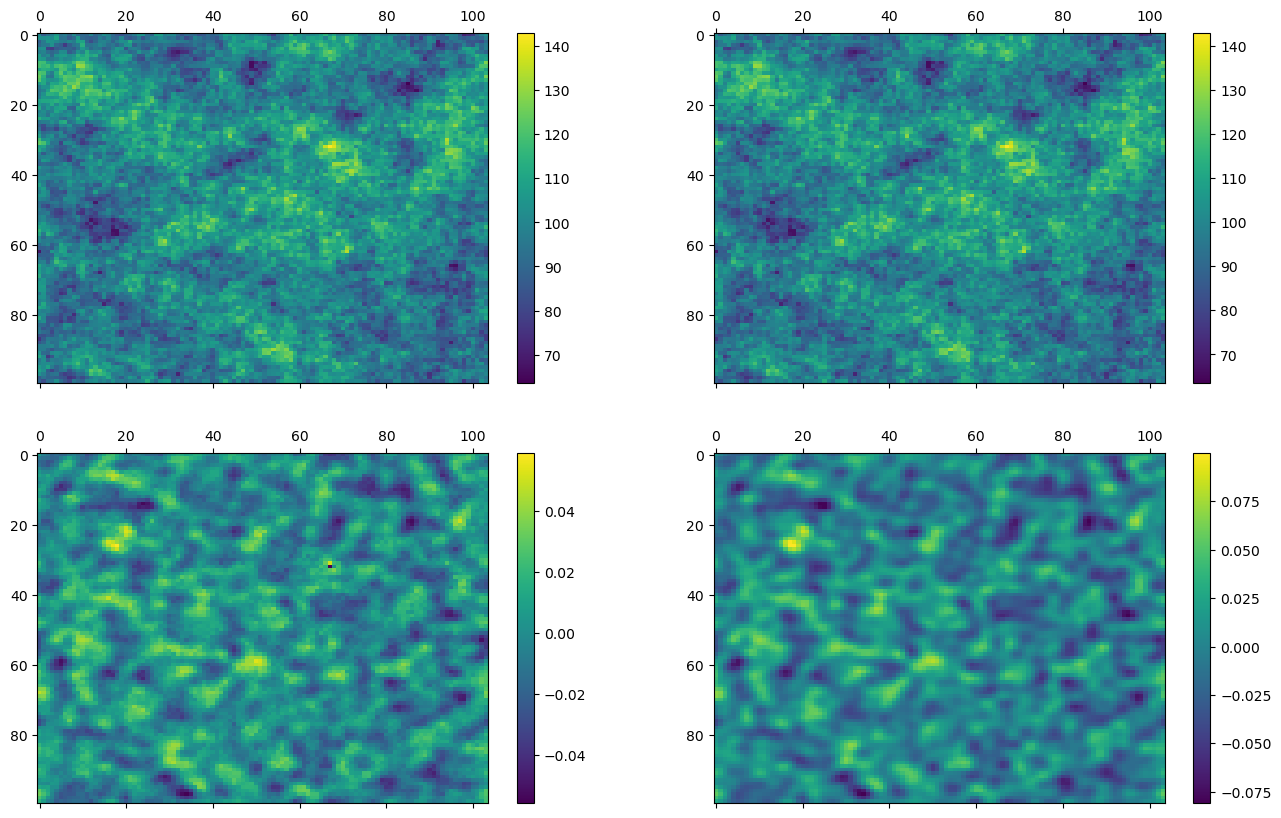

In [23]:
x_map = unpack_solution(x_soln, rfft_shape, sqrtS=sqrtS)

# Plot slices
plt.subplot(221)
plt.matshow(fg_amp, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(222)
plt.matshow(x_map, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(223)
plt.matshow(x_map - fg_amp, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(224)
plt.matshow(np.mean(s, axis=-1), aspect='auto', fignum=False)
plt.colorbar()

plt.gcf().set_size_inches((16., 10.))